## Task 2 — Store Trial Evaluation
### Objectives, Framework, Execution Plan

### 1. Business Objective

The objective of this analysis is to evaluate the performance of a new chip category store layout trial conducted in stores 77, 86, and 88, and to provide a data-driven recommendation on whether the layout should be rolled out more broadly.

Success is defined as a statistically and commercially meaningful improvement in performance relative to comparable control stores during the trial period.

### 2. Key Metrics

Performance will be evaluated using store-level monthly metrics:

* Total Sales Revenue
* Total Number of Customers
* Average Transactions per Customer

These metrics allow us to assess both value uplift and behavioural drivers of change.

### 3. Analytical Framework

This task follows an experimental evaluation framework:

* Trial stores are compared against carefully selected control stores.
* Pre-trial similarity is validated before any post-trial comparison.
* Statistical testing is used to distinguish real effects from random variation.

The unit of analysis is the store, not the customer or product.

### 4. Execution Flow

### Step 1 — Data Preparation

* Load `QVI_data.csv` without category filtering or enrichment.
* Aggregate data to monthly store-level metrics.

### Step 2 — Pre-Trial Period Definition

* Define a stable pre-trial window.
* Validate similarity between trial and candidate control stores using trends and visualisation.

### Step 3 — Control Store Selection

* Select control stores using quantitative similarity measures (correlation, magnitude distance).
* Support selection with time-series visualisations.

### Step 4 — Trial Impact Assessment

* Compare trial vs control performance during the trial period.
* Measure uplift in sales, customers, and transactions per customer.

### Step 5 — Statistical Validation

* Apply appropriate statistical tests to assess significance of observed differences.
* Report effect sizes alongside statistical confidence.

### Step 6 — Interpretation & Recommendation

* Summarise findings for each trial store individually.
* Provide a clear recommendation supported by data and visual evidence.

### 5. Scope & Constraints

This analysis intentionally excludes:

* customer segmentation,
* brand or pack-size analysis,
* category redefinition or filtering.

The focus is on causal evaluation, not behavioural explanation.

### 6. Expected Outcome

The final output will provide:

* clear evidence of whether the trial worked,
* quantified uplift where present,
* a defensible recommendation for Julia's category review.

## Step 1 — Implement the Experimental Setup (Python)

### 1️⃣ Lock the experiment definition


#### Section: Experimental Setup

* **Trial stores:** 77, 86, 88
* **Unit of analysis:** Store × Month
* **Outcome metrics:**
   * Total sales revenue
   * Number of unique customers
   * Transactions per customer
* **Periods:**
   * Pre-trial: Jul 2018 – Jan 2019
   * Trial: Feb 2019 – Apr 2019

📌 This is non-negotiable documentation. Anyone reading your notebook must understand the experiment before seeing code.

---

### 2️⃣ Prepare time variables (structural, not analytical)

You already have `DATE` as datetime. Now you need month granularity.

#### What to implement

* Extract:
   * `YEAR`
   * `MONTH`
   * `YEARMONTH` (e.g. 2018-07)

#### Why

* Monthly aggregation is required
* Store-level daily noise will destroy trend comparability

#### Expected result

* One row can later represent: `(STORE_NBR, YEARMONTH)`

---

### 3️⃣ Define trial & pre-trial flags (explicit, not implicit)

Create two boolean columns:

* `is_trial_store`
* `period` → `"pre"` or `"trial"`

#### Rules

* `is_trial_store = True` if store in `{77, 86, 88}`
* `period = "pre"` if date ∈ pre-trial window
* `period = "trial"` if date ∈ trial window
* Drop everything else (we do not need post-trial)

📌 Do not mix logic into later steps. This separation is what makes the analysis auditable.

---

### 4️⃣ Aggregate to Store × Month level (THIS IS CRITICAL)

Now aggregate once and only once.

#### Group by
```
STORE_NBR, YEARMONTH, period, is_trial_store
```

#### Compute metrics

* `total_sales` → sum(TOT_SALES)
* `num_customers` → nunique(LYLTY_CARD_NBR)
* `num_transactions` → nunique(TXN_ID)
* `transactions_per_customer` = num_transactions / num_customers

📌 These are the only metrics allowed at this stage.

---

### 5️⃣ Sanity checks (MANDATORY)

Before moving on, verify:

1. Trial stores have:
   * multiple months in pre
   * multiple months in trial
2. Non-trial stores exist in both periods
3. No missing values in aggregated metrics
4. Each `(STORE_NBR, YEARMONTH)` appears once

If any of these fail → stop.

---

### 6️⃣ What Step 1 output should look like

Your final dataframe (call it something like `monthly_store_metrics`) should have columns:
```
STORE_NBR
YEARMONTH
period
is_trial_store
total_sales
num_customers
num_transactions
transactions_per_customer
```

And rows like:
```
Store 77 | 2018-10 | pre   | True  | ...
Store 77 | 2019-03 | trial | True  | ...
Store 123| 2018-10 | pre   | False | ...
```

This dataset is the foundation of the experiment.

In [30]:
import numpy as np
import pandas as pd 

qvi = pd.read_csv("C:/Users/adith/quantium_data_analytics/data/QVI_data.csv")
qvi.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [31]:
qvi['DATE'] = pd.to_datetime(qvi['DATE'])
qvi[['DATE']].head()

,DATE
0,2018-10-17
1,2018-09-16
2,2019-03-07
3,2019-03-08
4,2018-11-02


In [32]:
yearmonth = qvi['YEARMONTH'] = qvi['DATE'].dt.to_period('M')
yearmonth

0         2018-10
1         2018-09
2         2019-03
3         2019-03
4         2018-11
           ...   
264829    2018-12
264830    2018-10
264831    2018-10
264832    2018-10
264833    2018-12
Name: DATE, Length: 264834, dtype: period[M]

In [5]:
qvi['YEAR'] = qvi['DATE'].dt.year
qvi['MONTH'] = qvi['DATE'].dt.month
year = qvi['YEAR']
month = qvi['MONTH']
year, month

(0         2018
 1         2018
 2         2019
 3         2019
 4         2018
           ... 
 264829    2018
 264830    2018
 264831    2018
 264832    2018
 264833    2018
 Name: YEAR, Length: 264834, dtype: int32,
 0         10
 1          9
 2          3
 3          3
 4         11
           ..
 264829    12
 264830    10
 264831    10
 264832    10
 264833    12
 Name: MONTH, Length: 264834, dtype: int32)

In [6]:
# define trial stores
TRIAL_STORES = [77, 86, 88]
qvi['is_trial_store'] = qvi['STORE_NBR'].isin(TRIAL_STORES)

In [7]:
qvi.groupby('is_trial_store')['STORE_NBR'].nunique()

is_trial_store
False    269
True       3
Name: STORE_NBR, dtype: int64

In [8]:
# define experimental periods
pre_start = pd.Timestamp('2018-07-01')
pre_end = pd.Timestamp('2019-01-31')

trial_start = pd.Timestamp('2019-02-01')
trial_end = pd.Timestamp('2019-04-30')


In [9]:
qvi['period'] = np.where(
    (qvi['DATE'] >= pre_start) & (qvi['DATE'] <= pre_end), 'pre_trial',
    np.where(
        (qvi['DATE'] >= trial_start) & (qvi['DATE'] <= trial_end), 'trial',
        'other'
    )
)

In [10]:
qvi = qvi[qvi['period'].isin(['pre_trial', 'trial'])].copy()

In [11]:
# Aggregate to store x month level
monthly_store_metrics = (
    qvi
    .groupby(['STORE_NBR', 'YEARMONTH', 'period', 'is_trial_store'])
    .agg(
        total_sales=('TOT_SALES', 'sum'),
        num_customers=('LYLTY_CARD_NBR', 'nunique'),
        num_transactions=('TXN_ID', 'nunique')
    )
    .reset_index()
)

In [12]:
monthly_store_metrics['transactions_per_customer'] = (
    monthly_store_metrics['num_transactions'] /
    monthly_store_metrics['num_customers']
)

In [13]:
monthly_store_metrics[
    monthly_store_metrics['is_trial_store']
    ].groupby(['STORE_NBR', 'period'])['YEARMONTH'].nunique()

STORE_NBR  period   
77         pre_trial    7
           trial        3
86         pre_trial    7
           trial        3
88         pre_trial    7
           trial        3
Name: YEARMONTH, dtype: int64

In [14]:
monthly_store_metrics.isna().sum()

STORE_NBR                    0
YEARMONTH                    0
period                       0
is_trial_store               0
total_sales                  0
num_customers                0
num_transactions             0
transactions_per_customer    0
dtype: int64

In [15]:
monthly_store_metrics.duplicated(
    subset=['STORE_NBR', 'YEARMONTH']
).sum()

np.int64(0)

In [16]:
monthly_store_metrics.head()

,STORE_NBR,YEARMONTH,period,is_trial_store,total_sales,num_customers,num_transactions,transactions_per_customer
0,1,2018-07,pre_trial,False,206.9,49,52,1.061224
1,1,2018-08,pre_trial,False,176.1,42,43,1.023810
2,1,2018-09,pre_trial,False,278.8,59,62,1.050847
3,1,2018-10,pre_trial,False,188.1,44,45,1.022727
4,1,2018-11,pre_trial,False,192.6,46,47,1.021739


In [17]:
# save monthly store metrics to csv
monthly_store_metrics.to_csv(
    "C:/Users/adith/quantium_data_analytics/data/monthly_store_metrics.csv",
    index=False
)

### 📘 STEP 1 — Experimental Setup



---

#### Step 1: Experimental Setup

##### Objective

Prepare an analysis-ready dataset to evaluate the impact of the new store layout by comparing trial stores against control stores using a before–after experimental design.

##### Trial Design

* **Trial Stores:** 77, 86, 88
* **Control Stores:** All remaining stores not exposed to the trial
* **Unit of Analysis:** Store × Month

##### Time Windows

* **Pre-Trial Period:** 7 months
* **Trial Period:** 3 months

Each trial store has:

* 7 monthly observations before the trial
* 3 monthly observations during the trial

This ensures sufficient data to compare pre-trial behaviour and trends.

##### Feature Engineering

From transactional data, we constructed monthly store-level metrics:

* `total_sales` — total chip sales per store per month
* `num_customers` — unique loyalty card holders per store per month
* `num_transactions` — number of transactions per store per month

Additional flags:

* `YEARMONTH` — monthly period (`Period[M]`)
* `period` — categorical label (`pre_trial`, `trial`)
* `is_trial_store` — boolean flag for trial stores

##### Final Dataset Structure
```
STORE_NBR | YEARMONTH | period | is_trial_store | total_sales | num_customers | num_transactions
```

##### Validation Checks

* No missing values across all metrics
* No duplicate store–month records
* Exactly 3 trial stores identified
* Correct pre-trial and trial month counts per trial store

##### Outcome

A clean, validated monthly store-level dataset ready for:

* control store selection (pre-trial only)
* uplift comparison during the trial period
* statistical testing of sales impact

### Implementing control store selection 

In [33]:
# Prepare pre-trial dataset

pre_trial_data = monthly_store_metrics[
    monthly_store_metrics['period'] == 'pre_trial'
].copy()

In [34]:
control_candidates = pre_trial_data[
    ~pre_trial_data['is_trial_store']
]

In [35]:
def aligned_series(trial_df, control_df, metric):
    merged = pd.merge(
        trial_df[['YEARMONTH', metric]],
        control_df[['YEARMONTH', metric]],
        on='YEARMONTH',
        suffixes=('_trial', '_control')
    )
    return merged[f'{metric}_trial'], merged[f'{metric}_control']

In [36]:
def safe_correlation(x, y):
    if x.std() == 0 or y.std() == 0:
        return 0 # treat as no similarity, not NaN
    return x.corr(y)

In [37]:
## helper functions
# 1. Pearson correlation
"""def calc_correlation(trial_series, control_series):
    return trial_series.corr(control_series)"""
def compute_metric_similarity(trial_df, control_df, metric):
    x, y = aligned_series(trial_df, control_df, metric)
    
    corr = safe_correlation(x, y)
    dist = np.mean(np.abs(x - y))
    
    return corr, dist

# 2. Magnitude distance score
def calc_magnitude_score(trial_series, control_series):
    distances = abs(trial_series.values - control_series.values)
    mean_distance = distances.mean()
    return mean_distance


In [38]:
# Core similarity function
def find_control_store(trial_store_id, data):
    trial_df = data[data['STORE_NBR'] == trial_store_id]

    results = []

    for store in data['STORE_NBR'].unique():
        if store == trial_store_id:
            continue

        control_df = data[data['STORE_NBR'] == store]

        if len(control_df) != len(trial_df):
            continue

        corr_scores = []
        dist_scores = []

        for metric in ['total_sales', 'num_customers', 'transactions_per_customer']:
            corr, dist = compute_metric_similarity(trial_df, control_df, metric)
            corr_scores.append(corr)
            dist_scores.append(dist)

        results.append({
            'control_store': store,
            'corr_scores': corr_scores,
            'dist_scores': dist_scores
        })

    scores = pd.DataFrame(results)

    # Normalise distances → magnitude scores
    for i in range(3):
        d = scores['dist_scores'].apply(lambda x: x[i])
        scores[f'magnitude_{i}'] = 1 - (d - d.min()) / (d.max() - d.min())
        scores[f'corr_{i}'] = scores['corr_scores'].apply(lambda x: x[i])
        scores[f'sim_{i}'] = (scores[f'magnitude_{i}'] + scores[f'corr_{i}']) / 2

    scores['overall_similarity'] = scores[[f'sim_{i}' for i in range(3)]].mean(axis=1)

    return scores.sort_values('overall_similarity', ascending=False)




In [39]:
control_77 = find_control_store(77, pre_trial_data)
control_86 = find_control_store(86, pre_trial_data)
control_88 = find_control_store(88, pre_trial_data)

In [41]:

#control_77.head(5)
# return row where control store is 233
control_77[control_77['control_store'] == 233]


,control_store,corr_scores,dist_scores,magnitude_0,corr_0,sim_0,magnitude_1,corr_1,sim_1,magnitude_2,corr_2,sim_2,overall_similarity
220,233,"[0.9037741879865313, 0.9903577884027611, -0.49...","[18.82857142857143, 0.7142857142857143, 0.0354...",1.0,0.903774,0.951887,1.0,0.990358,0.995179,0.939618,-0.496183,0.221718,0.722928


In [42]:
control_77.head(5)

,control_store,corr_scores,dist_scores,magnitude_0,corr_0,sim_0,magnitude_1,corr_1,sim_1,magnitude_2,corr_2,sim_2,overall_similarity
15,17,"[0.8426683602788766, 0.7473077598310776, 0.423...","[155.61428571428573, 3.5714285714285716, 0.034...",0.886125,0.842668,0.864397,0.969136,0.747308,0.858222,0.945539,0.423245,0.684392,0.802337
78,84,"[0.6843478453990107, 0.8585712385350364, 0.396...","[219.92857142857142, 7.428571428571429, 0.0341...",0.832583,0.684348,0.758465,0.927469,0.858571,0.893020,0.945114,0.396508,0.670811,0.774099
136,145,"[0.43064238117384507, 0.6811550791229825, 0.60...","[80.97142857142855, 4.428571428571429, 0.02963...",0.948266,0.430642,0.689454,0.959877,0.681155,0.820516,0.963784,0.601015,0.782399,0.764123
107,115,"[0.6891588204916099, 0.7188817542625743, 0.303...","[87.65714285714284, 3.4285714285714284, 0.0344...",0.942700,0.689159,0.815929,0.970679,0.718882,0.844780,0.943845,0.303872,0.623858,0.761523
34,37,"[0.4375957166946285, 0.4940161673358257, 0.715...","[170.47857142857143, 7.285714285714286, 0.0216...",0.873750,0.437596,0.655673,0.929012,0.494016,0.711514,0.996878,0.715181,0.856030,0.741072


In [24]:
control_86.head(5)

,control_store,corr_scores,dist_scores,magnitude_0,corr_0,sim_0,magnitude_1,corr_1,sim_1,magnitude_2,corr_2,sim_2,overall_similarity
129,138,"[0.7598637683047484, 0.7497007395374065, 0.543...","[65.43571428571428, 7.0, 0.04400436697717924]",0.959103,0.759864,0.859483,0.940998,0.749701,0.845350,0.898723,0.543144,0.720934,0.808589
106,114,"[0.7344154920107472, 0.8553390499905145, 0.226...","[68.75714285714287, 6.285714285714286, 0.04926...",0.955087,0.734415,0.844751,0.948563,0.855339,0.901951,0.876502,0.226550,0.551526,0.766076
146,155,"[0.8778816901365498, 0.9428756256686046, -0.07...","[32.464285714285715, 1.4285714285714286, 0.072...",0.998964,0.877882,0.938423,1.000000,0.942876,0.971438,0.780421,-0.070774,0.354823,0.754895
257,271,"[0.527637266261391, 0.2673929950591565, 0.6490...","[69.36428571428573, 6.428571428571429, 0.04107...",0.954353,0.527637,0.740995,0.947050,0.267393,0.607221,0.911078,0.649028,0.780053,0.709423
29,32,"[0.5438547078600143, 0.3520542199806849, 0.645...","[77.17857142857142, 8.857142857142858, 0.06631...",0.944906,0.543855,0.744380,0.921331,0.352054,0.636693,0.804546,0.645999,0.725273,0.702115


In [44]:
# where control store is 237
control_88.head(5)

,control_store,corr_scores,dist_scores,magnitude_0,corr_0,sim_0,magnitude_1,corr_1,sim_1,magnitude_2,corr_2,sim_2,overall_similarity
169,178,"[0.7318567026263824, 0.9394660416930009, 0.333...","[405.58571428571435, 22.142857142857142, 0.056...",0.725911,0.731857,0.728884,0.829181,0.939466,0.884324,0.861008,0.333328,0.597168,0.736792
191,201,"[0.4927349840222274, 0.5113021023604992, 0.707...","[169.74285714285716, 9.857142857142858, 0.0575...",0.912115,0.492735,0.702425,0.931198,0.511302,0.721250,0.854281,0.707710,0.780996,0.734890
98,106,"[0.6447244176207254, 0.20048224797995326, 0.80...","[399.5928571428572, 19.142857142857142, 0.0439...",0.730643,0.644724,0.687683,0.854093,0.200482,0.527287,0.926374,0.803873,0.865123,0.693365
105,113,"[0.4957630545079048, 0.862632350900331, 0.5558...","[422.8714285714286, 26.714285714285715, 0.0881...",0.712264,0.495763,0.604013,0.791222,0.862632,0.826927,0.690600,0.555803,0.623202,0.684714
114,123,"[0.399761007849132, 0.6279252888472046, 0.3790...","[191.32857142857145, 13.0, 0.05258271231758698]",0.895072,0.399761,0.647417,0.905101,0.627925,0.766513,0.880547,0.379035,0.629791,0.681240


In [45]:
def get_pretrial_pair(monthly_df, trial_store, control_store):
    return monthly_df[
        (monthly_df["STORE_NBR"].isin([trial_store, control_store])) &
        (monthly_df["period"] == "pre_trial")
    ].copy()

In [46]:
import matplotlib.pyplot as plt 

def plot_pretrial_validation(df, trial_store, control_store):
    metrics = [
        ("total_sales", "Total Sales"),
        ("num_customers", "Number of Customers"),
        ("num_transactions", "Transactions per Month")
    ]
    fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)
    df = df.sort_values("YEARMONTH")
    df["month_label"] = df["YEARMONTH"].dt.strftime("%b")

    for ax, (metric, title) in zip(axes, metrics):
        for store, label, style in [
            (trial_store, "Trial Store", "-o"),
            (control_store, "Control Store", "--o")
        ]:
            store_df = df[df["STORE_NBR"] == store]
            ax.plot(
                store_df["month_label"].astype(str),
                store_df[metric],
                style,
                label=f"{label} {{store}}"
            )
        ax.set_title(title)
        ax.legend()
        ax.grid(True, alpha=0.3)
    plt.suptitle(
        f"Pre-Trial Trend Validation: Store {trial_store} vs Store {control_store}",
        fontsize=14
    )
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


#### Pair1: Store 77 vs Store 17

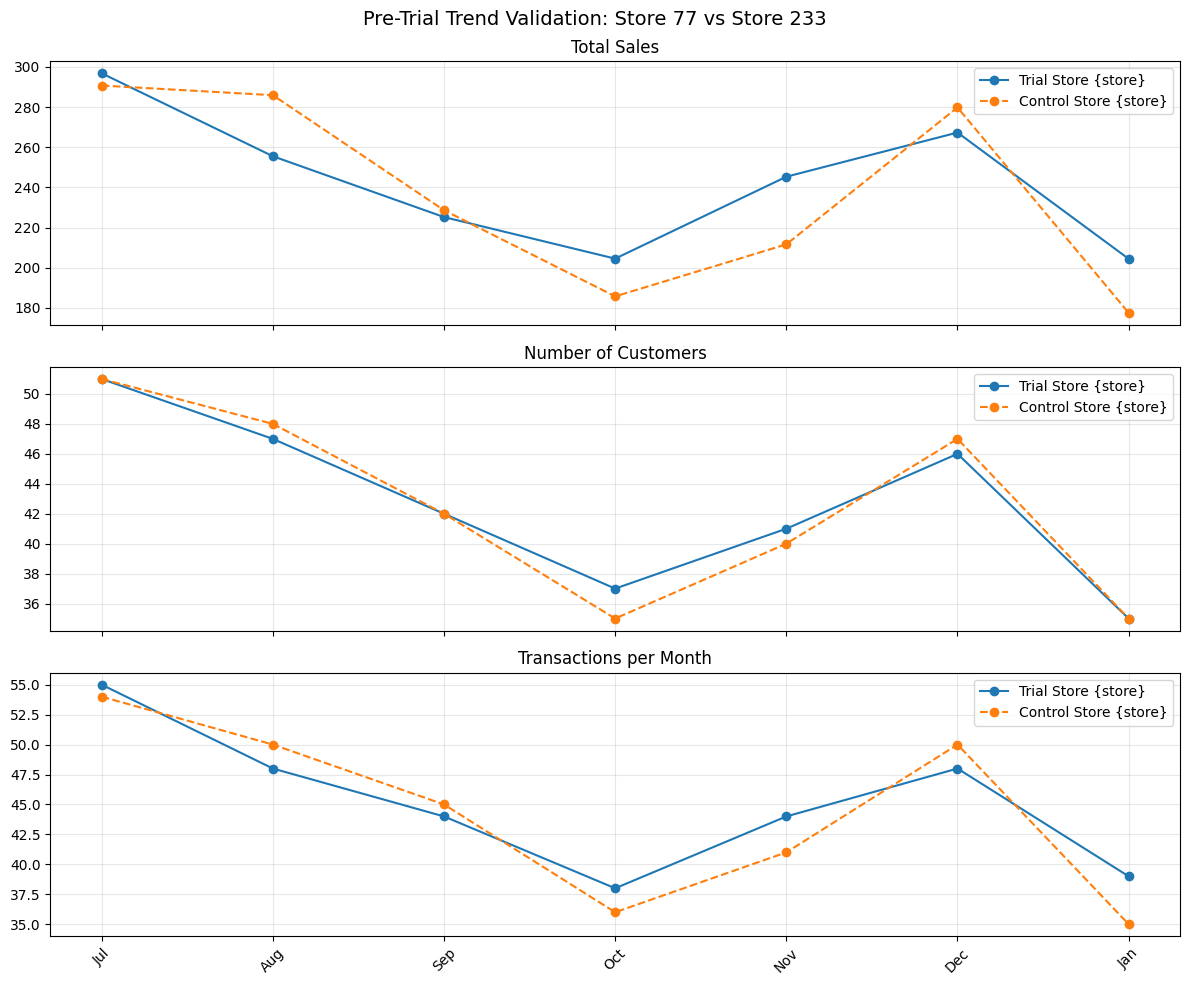

In [47]:
df_77_233 = get_pretrial_pair(monthly_store_metrics, 77, 233)
plot_pretrial_validation(df_77_233, 77, 233)


#### Pair 2: Store 86 vs Store 178

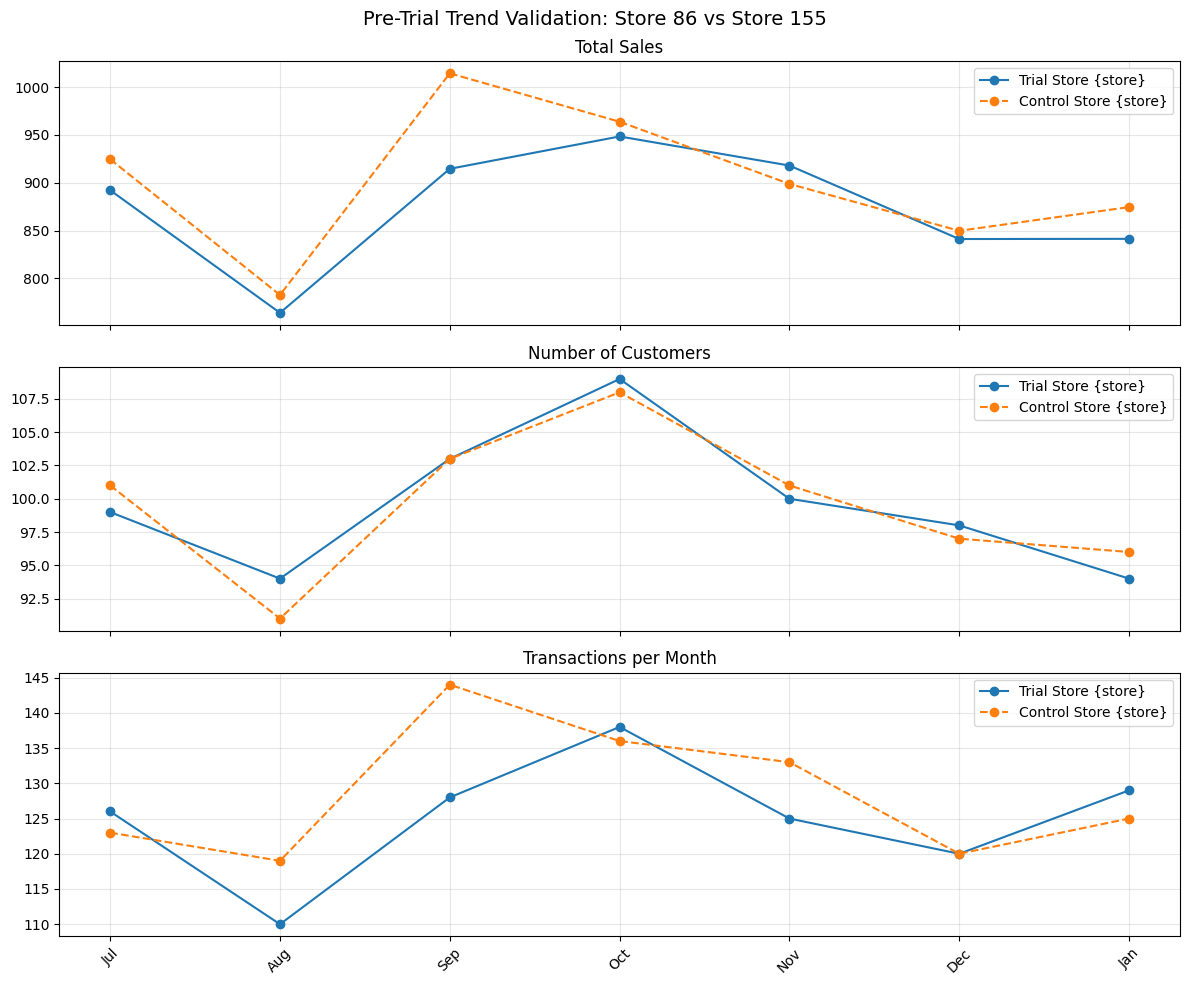

In [48]:
df_86_155 = get_pretrial_pair(monthly_store_metrics, 86, 155)
plot_pretrial_validation(df_86_155, 86, 155)


#### Pair 3: Store 88 vs Store 178

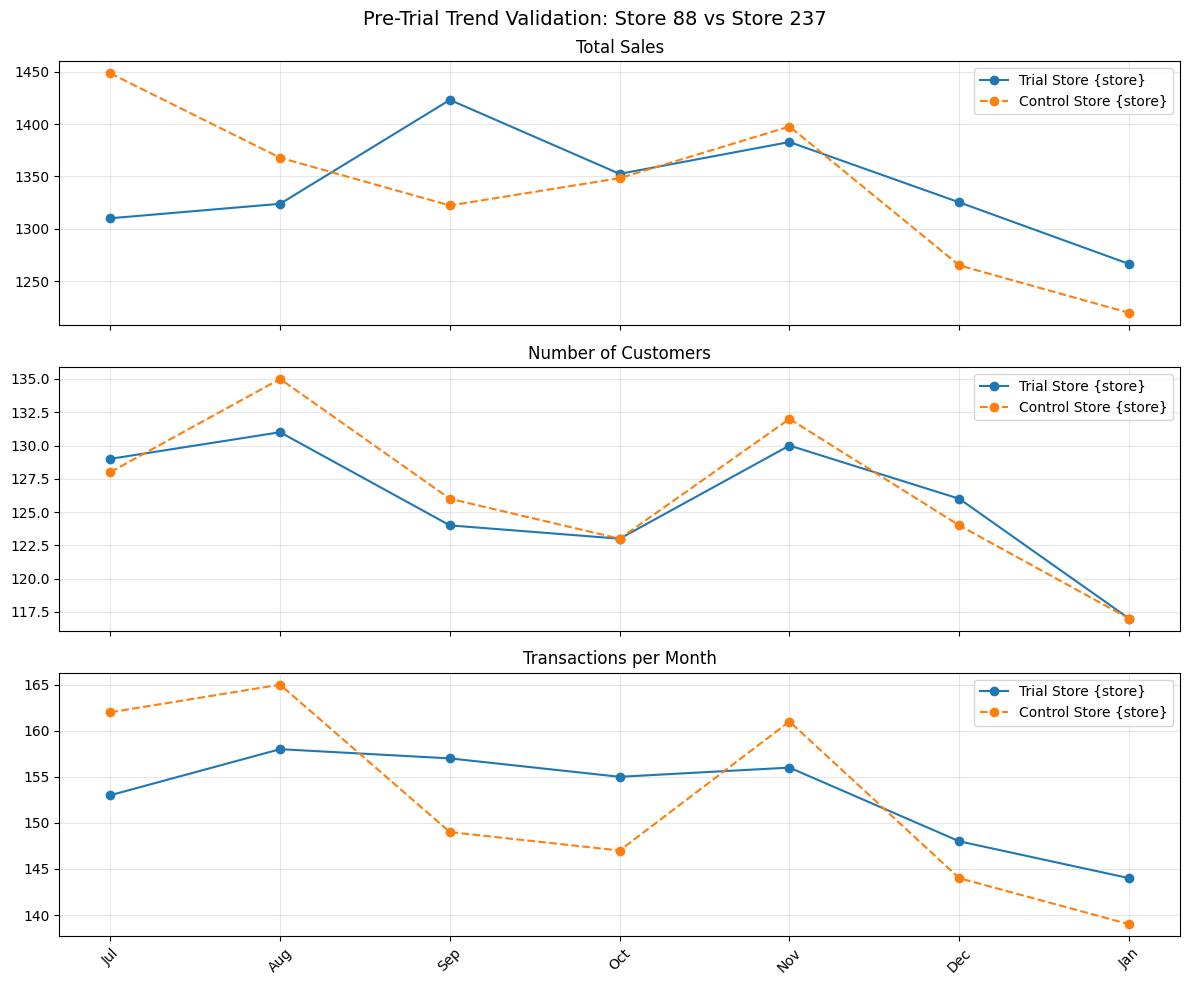

In [51]:
df_88_237 = get_pretrial_pair(monthly_store_metrics, 88, 237)
plot_pretrial_validation(df_88_237, 88, 237)



### Step 2 — Control Store Selection & Pre-Trial Validation

#### Objective

To identify appropriate control stores for each trial store (77, 86, 88) by ensuring pre-trial similarity across key performance metrics. This is a critical prerequisite for causal inference in a trial vs control experiment.

#### Why This Step Matters

A control store represents the **counterfactual** — what would have happened to the trial store had the layout change not been implemented.

For a valid comparison:

* Trial and control stores must behave similarly before the trial
* Any post-trial difference can then be attributed to the intervention, not structural differences

#### Metrics Used for Control Selection

Control stores were evaluated using monthly pre-trial data on:

1. Total Sales Revenue
2. Number of Customers
3. Number of Transactions

These metrics capture both value and volume behaviour.

#### Similarity Methodology

For each trial store, all candidate control stores were scored using a composite similarity metric:

* Pearson correlation (trend similarity)
* Magnitude distance (absolute level similarity), normalised as:
$$1 - \frac{d - d_{\min}}{d_{\max} - d_{\min}}$$

The final similarity score is the average across all metrics.

This balances:

* Directional behaviour (trends)
* Scale behaviour (levels)

#### Selected Control Stores

Based on highest overall similarity scores:

| Trial Store | Control Store |
|-------------|---------------|
| 77 | 233 |
| 86 | 155 |
| 88 | 237 |

#### Pre-Trial Visual Validation

For each trial–control pair, we visually validated pre-trial trends across:

* Total sales
* Number of customers
* Transactions per month

**Visual Checks Confirm:**

* Similar movement patterns over time
* No structural divergence before the trial
* Comparable seasonal behaviour

These plots confirm that statistical comparison during the trial period is valid.

#### Conclusion

Control stores for all three trial locations demonstrate strong pre-trial alignment across key metrics. This satisfies the core experimental assumption required to proceed to trial impact assessment.

#### Step 3 - trial impact Assessment

**4.1 Define the trial period clearly**

You already have this implicitly via period == "trial".


In [52]:
trial_store = 77 
control_store = 233

trial_period_77 = monthly_store_metrics[
    (monthly_store_metrics["STORE_NBR"] == trial_store) &
    (monthly_store_metrics["period"] == "trial")
]

control_period_77 = monthly_store_metrics[
    (monthly_store_metrics["STORE_NBR"] == control_store) &
    (monthly_store_metrics["period"] == "trial")
]
trial_period_77, control_period_77


(     STORE_NBR YEARMONTH period  is_trial_store  total_sales  num_customers  \
 741         77   2019-02  trial            True        235.0             45   
 742         77   2019-03  trial            True        278.5             50   
 743         77   2019-04  trial            True        263.5             47   
 
      num_transactions  transactions_per_customer  
 741                45                   1.000000  
 742                55                   1.100000  
 743                48                   1.021277  ,
       STORE_NBR YEARMONTH period  is_trial_store  total_sales  num_customers  \
 2257        233   2019-02  trial           False        244.0             45   
 2258        233   2019-03  trial           False        199.1             40   
 2259        233   2019-04  trial           False        158.6             30   
 
       num_transactions  transactions_per_customer  
 2257                47                   1.044444  
 2258                41              

In [53]:
assert len(trial_period_77) == 3
assert len(control_period_77) == 3
assert all(trial_period_77["YEARMONTH"].values == control_period_77["YEARMONTH"])

### 🔹 Step 3.2 — Construct the Counterfactual (Store 77)

#### 1️⃣ What are we doing (conceptually)

We want to answer:

**"What would Store 77's sales/customers/transactions have been during Feb–Apr 2019 if the trial had NOT happened?"**

We cannot observe this directly, so we approximate it using the control store (Store 233).

**Key assumption (already validated in Step 3):**

* Before the trial, Store 77 and Store 233 move together proportionally

So during the trial:

* If Store 233 goes up/down normally
* Store 77 should go up/down in the same proportion without the trial

That "should have" is the **counterfactual**.

#### 2️⃣ The math (this must be clear)

For each metric $m \in \{\text{sales}, \text{customers}, \text{transactions per customer}\}$:

### Pre-trial scaling factor

$$\text{Scaling}_m = \frac{\text{mean}(m_{\text{trial, pre}})} {\text{mean}(m_{\text{control, pre}})}$$

This captures:

* size differences
* structural differences
* baseline level differences

### Expected (counterfactual) during trial

$$\text{Expected}_{m,\;t} = \text{Scaling}_m \times m_{\text{control, trial},\;t}$$

### Uplift

$$\text{Uplift}_{m,\;t} = m_{\text{trial, trial},\;t} - \text{Expected}_{m,\;t}$$

This uplift is what the trial caused.

#### 3.2.1 - Split pre-trial and trial data 

In [54]:
metrics = ["total_sales", "num_customers", "transactions_per_customer"]
trial_pre = monthly_store_metrics[
    (monthly_store_metrics["STORE_NBR"] == trial_store) &
    (monthly_store_metrics["period"] == "pre_trial")
]

control_pre = monthly_store_metrics[
    (monthly_store_metrics["STORE_NBR"] == control_store) &
    (monthly_store_metrics["period"] == "pre_trial")
]

trial_trial = monthly_store_metrics[
    (monthly_store_metrics["STORE_NBR"] == trial_store) &
    (monthly_store_metrics["period"] == "trial")
]

control_trial = monthly_store_metrics[
    (monthly_store_metrics["STORE_NBR"] == control_store) &
    (monthly_store_metrics["period"] == "trial")
]

#### 3.2.2 -- Compute scaling factors 

In [55]:
scaling_factors = {}
for metric in metrics:
    scaling_factors[metric] = (
        trial_pre[metric].mean() /
        control_pre[metric].mean()
    )
    scaling_factors
    # this dictionary is critical.
    # it encodes the historical relationship between trial and control.

In [75]:
def compute_pretrial_std(trial_df, control_df, metric, scaling_factor):
    pre = trial_df.merge(
        control_df,
        on="YEARMONTH",
        suffixes=("_trial", "_control")
    )

    pct_diff = (
        pre[f"{metric}_trial"] -
        pre[f"{metric}_control"] * scaling_factor
    ) / (pre[f"{metric}_control"] * scaling_factor)

    return pct_diff.std()



In [76]:
std_sales_77 = compute_pretrial_std(
    trial_pre,
    control_pre,
    metric="total_sales",
    scaling_factor=scaling_factors["total_sales"]
)

#### 3.2.3 -- Build the counterfactual 


In [77]:
counterfactual_77 = control_trial[["YEARMONTH"]].copy()

for metric in metrics:
    counterfactual_77[f"expected_{metric}"] = (
        control_trial[metric].values * scaling_factors[metric]
    )

counterfactual_77


,YEARMONTH,expected_total_sales,expected_num_customers,expected_transactions_per_customer
2257,2019-02,249.762622,45.151007,1.061061
2258,2019-03,203.802205,40.134228,1.041307
2259,2019-04,162.345704,30.100671,1.083637


#### 3.2.4 -- Combine with actual trial performance

In [78]:
actual_77 = trial_trial[
    ["YEARMONTH"] + metrics
].reset_index(drop=True)

impact_77 = actual_77.merge(
    counterfactual_77,
    on="YEARMONTH"
)

for metric in metrics:
    impact_77[f"uplift_{metric}"] = (
        impact_77[metric] - impact_77[f"expected_{metric}"]
    )

impact_77


,YEARMONTH,total_sales,num_customers,transactions_per_customer,expected_total_sales,expected_num_customers,expected_transactions_per_customer,uplift_total_sales,uplift_num_customers,uplift_transactions_per_customer
0,2019-02,235.0,45,1.000000,249.762622,45.151007,1.061061,-14.762622,-0.151007,-0.061061
1,2019-03,278.5,50,1.100000,203.802205,40.134228,1.041307,74.697795,9.865772,0.058693
2,2019-04,263.5,47,1.021277,162.345704,30.100671,1.083637,101.154296,16.899329,-0.062360


#### Visualising Trial Impact (Store 77)

In [58]:
impact_77.columns

Index(['YEARMONTH', 'total_sales', 'num_customers',
       'transactions_per_customer', 'expected_total_sales',
       'expected_num_customers', 'expected_transactions_per_customer',
       'uplift_total_sales', 'uplift_num_customers',
       'uplift_transactions_per_customer'],
      dtype='object')

In [71]:
impact_77["month_label"] = impact_77["YEARMONTH"].dt.strftime("%b %Y")

In [79]:
impact_77["upper_ci_sales"] = (
    impact_77["expected_total_sales"] * (1 + 2 * std_sales_77)
)

impact_77["lower_ci_sales"] = (
    impact_77["expected_total_sales"] * (1 - 2 * std_sales_77)
)


#### Actual vs Expected - total sales

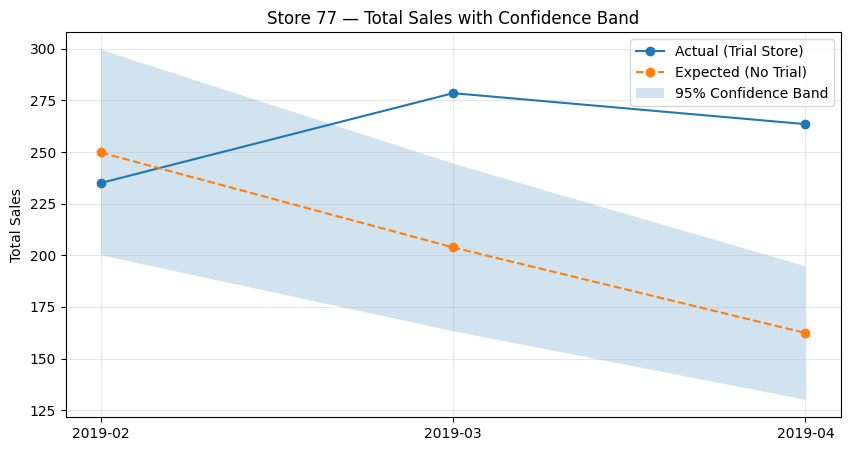

In [80]:
plt.figure(figsize=(10,5))



plt.plot(
    impact_77["YEARMONTH"].astype(str),
    impact_77["total_sales"],
    marker="o",
    label="Actual (Trial Store)"
)

plt.plot(
    impact_77["YEARMONTH"].astype(str),
    impact_77["expected_total_sales"],
    linestyle="--",
    marker="o",
    label="Expected (No Trial)"
)

plt.fill_between(
    impact_77["YEARMONTH"].astype(str),
    impact_77["lower_ci_sales"],
    impact_77["upper_ci_sales"],
    alpha=0.2,
    label="95% Confidence Band"
)

plt.title("Store 77 — Total Sales with Confidence Band")
plt.ylabel("Total Sales")
plt.legend()
plt.grid(alpha=0.3)
plt.show()



In [81]:
print("Pre-trial std (sales % diff):", std_sales_77)


Pre-trial std (sales % diff): 0.09958646884078383


#### Uplift - Total Sales 

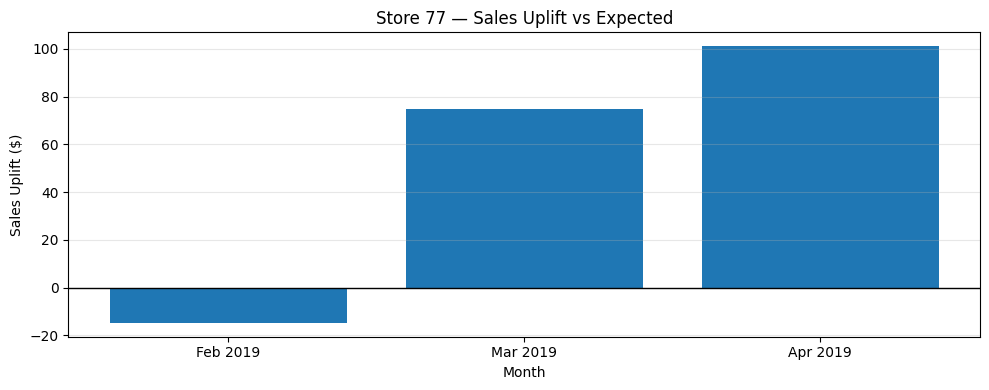

In [61]:
plt.figure(figsize=(10,4))

plt.bar(
    impact_77["month_label"],
    impact_77["uplift_total_sales"]
)

plt.axhline(0, color="black", linewidth=1)
plt.title("Store 77 — Sales Uplift vs Expected")
plt.ylabel("Sales Uplift ($)")
plt.xlabel("Month")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


#### Repeat for Number of Customers
**Actual vs Expected**

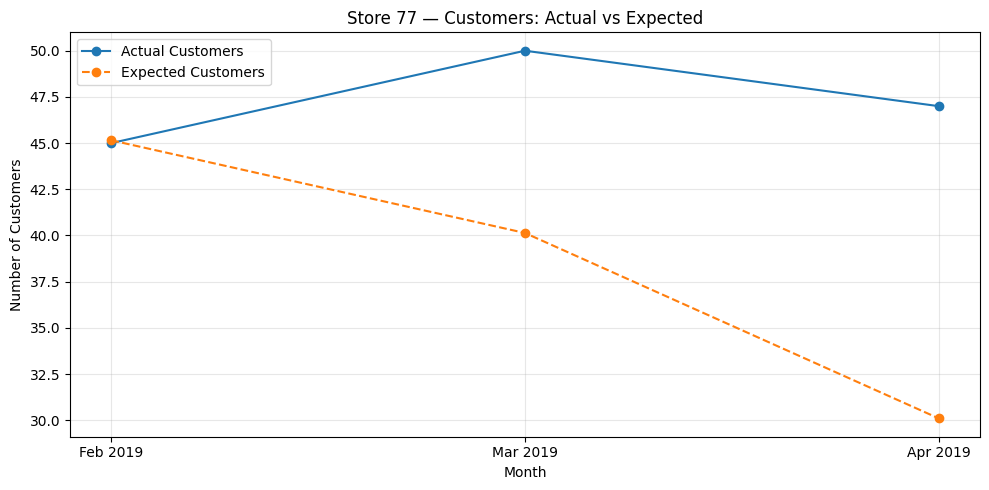

In [62]:
plt.figure(figsize=(10,5))

plt.plot(
    impact_77["month_label"],
    impact_77["num_customers"],
    marker="o",
    label="Actual Customers"
)

plt.plot(
    impact_77["month_label"],
    impact_77["expected_num_customers"],
    marker="o",
    linestyle="--",
    label="Expected Customers"
)

plt.title("Store 77 — Customers: Actual vs Expected")
plt.ylabel("Number of Customers")
plt.xlabel("Month")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


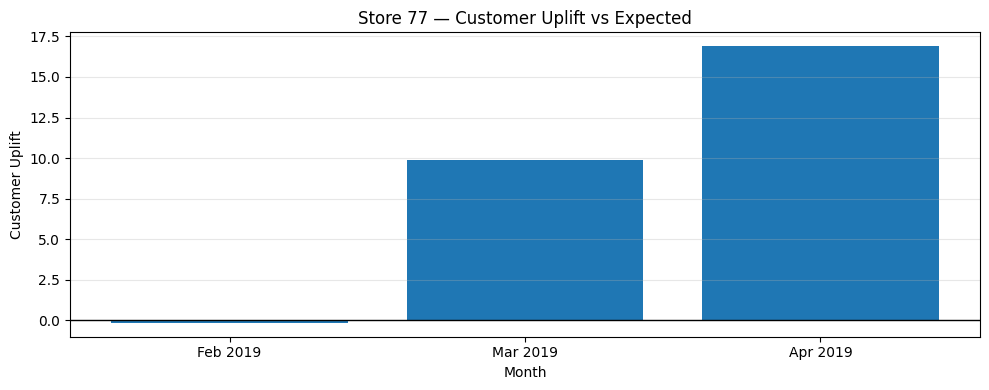

In [63]:
plt.figure(figsize=(10,4))

plt.bar(
    impact_77["month_label"],
    impact_77["uplift_num_customers"]
)

plt.axhline(0, color="black", linewidth=1)
plt.title("Store 77 — Customer Uplift vs Expected")
plt.ylabel("Customer Uplift")
plt.xlabel("Month")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


#### Transactions per Customer 
**Actual vs Expected**

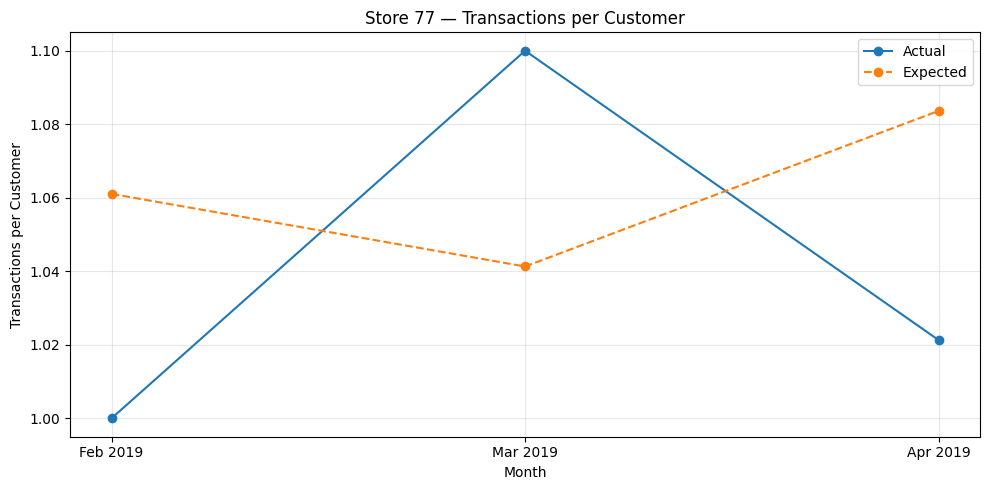

In [64]:
plt.figure(figsize=(10,5))

plt.plot(
    impact_77["month_label"],
    impact_77["transactions_per_customer"],
    marker="o",
    label="Actual"
)

plt.plot(
    impact_77["month_label"],
    impact_77["expected_transactions_per_customer"],
    marker="o",
    linestyle="--",
    label="Expected"
)

plt.title("Store 77 — Transactions per Customer")
plt.ylabel("Transactions per Customer")
plt.xlabel("Month")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


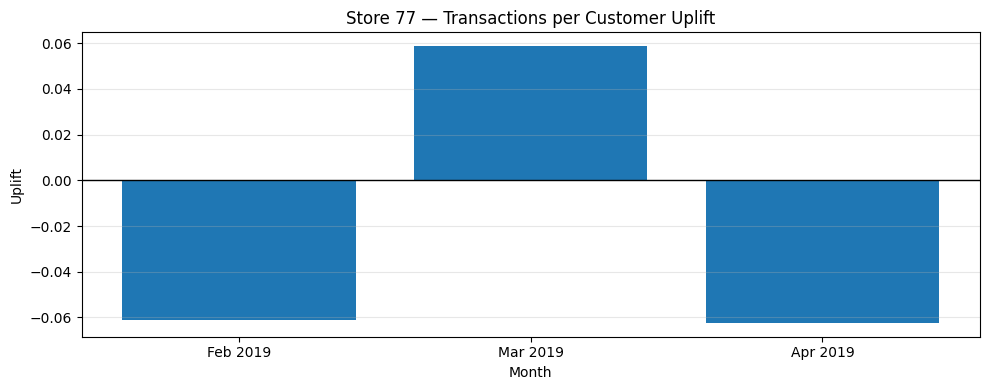

In [65]:
plt.figure(figsize=(10,4))

plt.bar(
    impact_77["month_label"],
    impact_77["uplift_transactions_per_customer"]
)

plt.axhline(0, color="black", linewidth=1)
plt.title("Store 77 — Transactions per Customer Uplift")
plt.ylabel("Uplift")
plt.xlabel("Month")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


### Step 3 — Trial Impact Assessment (Store 77)

#### 3.1 Objective

Evaluate whether the trial implemented in Store 77 led to a measurable uplift during the trial period by comparing observed performance against a counterfactual baseline derived from a matched control store.

#### 3.2 Trial Period Definition

* Trial period: February 2019 – April 2019
* All observations in this window are labelled `period = "trial"`
* Store 77 is flagged as `is_trial_store = True`

#### 3.3 Metrics Evaluated

The following monthly store-level metrics were analysed:

* `total_sales`
* `num_customers`
* `transactions_per_customer`

These metrics assess whether uplift was driven by:

* Increased revenue
* Increased footfall
* Increased purchasing intensity

#### 3.4 Control Store & Counterfactual Construction

Control Store 233 was selected based on strong pre-trial similarity in sales, customers, and transaction behaviour.

A counterfactual baseline was constructed by:

1. Computing pre-trial scaling factors between Store 77 and Store 233
2. Applying these factors to the control store's trial-period performance

This answers: "What would Store 77's performance have looked like had the trial not occurred?"

#### 3.5 Impact Calculation

For each metric and month:
```
Uplift = Actual_trial − Expected_counterfactual
```

#### 3.6 Visual Validation

Six visualisations were produced:

1. Actual vs Expected Total Sales (with confidence band)
2. Monthly Sales Uplift
3. Actual vs Expected Customers
4. Customer Uplift
5. Actual vs Expected Transactions per Customer
6. Transactions per Customer Uplift

A 95% confidence band was constructed using ±2 standard deviations of pre-trial percentage differences, providing a volatility-based benchmark.

#### 3.7 Interim Interpretation

* **Sales:** Clear uplift in March and April, exceeding expected values
* **Customers:** Consistent positive uplift across trial months
* **Transactions per customer:** No sustained increase

**Conclusion:** The observed sales uplift in Store 77 is primarily driven by increased customer traffic rather than increased basket size.

#### Trial Impact Assessment(Store 86)

Trial store: 86

Control store: 138

Trial period: Feb-Apr 2019

#### 3.1 Extract Trial-Period Data

In [84]:
trial_86 = monthly_store_metrics[
    (monthly_store_metrics["STORE_NBR"] == 86) &
    (monthly_store_metrics["period"] == "trial")
].copy()
control_155 = monthly_store_metrics[
    (monthly_store_metrics["STORE_NBR"] == 155) &
    (monthly_store_metrics["period"] == "trial")
].copy()
trial_86, control_155


(     STORE_NBR YEARMONTH period  is_trial_store  total_sales  num_customers  \
 822         86   2019-02  trial            True        913.2            107   
 823         86   2019-03  trial            True       1026.8            115   
 824         86   2019-04  trial            True        848.2            105   
 
      num_transactions  transactions_per_customer  
 822               138                   1.289720  
 823               140                   1.217391  
 824               126                   1.200000  ,
       STORE_NBR YEARMONTH period  is_trial_store  total_sales  num_customers  \
 1502        155   2019-02  trial           False        891.2             95   
 1503        155   2019-03  trial           False        804.4             94   
 1504        155   2019-04  trial           False        844.6             99   
 
       num_transactions  transactions_per_customer  
 1502               125                   1.315789  
 1503               118              

In [85]:
print("Trial Store 86 months:")
print(trial_86["YEARMONTH"].tolist())

print("\nControl Store 155 months:")
print(control_155["YEARMONTH"].tolist())


Trial Store 86 months:
[Period('2019-02', 'M'), Period('2019-03', 'M'), Period('2019-04', 'M')]

Control Store 155 months:
[Period('2019-02', 'M'), Period('2019-03', 'M'), Period('2019-04', 'M')]


In [86]:
trial_86 = (
    trial_86
    .sort_values("YEARMONTH")
    .reset_index(drop=True)
)

control_155 = (
    control_155
    .sort_values("YEARMONTH")
    .reset_index(drop=True)
)


In [87]:
assert len(trial_86) == 3
assert len(control_155) == 3
assert trial_86["YEARMONTH"].equals(control_155["YEARMONTH"])

### 3.2 Compute Pre-Trial Scaling Factors

In [90]:
pretrial = monthly_store_metrics[monthly_store_metrics["period"] == "pre_trial"]

trial_pre_86 = pretrial[pretrial["STORE_NBR"] == 86]
control_pre_155 = pretrial[pretrial["STORE_NBR"] == 155]


#### Computing scaling factors

In [91]:
scaling_factors_86 = {
    "total_sales": (
        trial_pre_86["total_sales"].mean() /
        control_pre_155["total_sales"].mean()
    ),
    "num_customers": (
        trial_pre_86["num_customers"].mean() /
        control_pre_155["num_customers"].mean()
    ),
    "transactions_per_customer": (
        trial_pre_86["transactions_per_customer"].mean() /
        control_pre_155["transactions_per_customer"].mean()
    )
}


In [92]:
scaling_factors_86


{'total_sales': np.float64(0.9700651481287743),
 'num_customers': np.float64(1.0),
 'transactions_per_customer': np.float64(0.9734129893618191)}

In [ ]:
"""def compute_pretrial_scaling_factors(
    df,
    trial_store,
    control_store,
    metrics=("total_sales", "num_customers", "transactions_per_customer")
):
    
    Computes scaling factors based on pre-trial means.

    Scaling Factor_M =
        mean(pre-trial M for trial store) /
        mean(pre-trial M for control store)


    # Filter pre-trial data
    pretrial = df[df["period"] == "pre_trial"]

    trial_pre = pretrial[pretrial["STORE_NBR"] == trial_store]
    control_pre = pretrial[pretrial["STORE_NBR"] == control_store]

    scaling_factors = {}

    for metric in metrics:
        trial_mean = trial_pre[metric].mean()
        control_mean = control_pre[metric].mean()

        scaling_factors[metric] = trial_mean / control_mean

    return scaling_factors """


#### 3.3 Build Counterfactual for Store 86


In [93]:
counterfactual_86 = control_155[["YEARMONTH"]].copy()

for metric, factor in scaling_factors_86.items():
    counterfactual_86[f"expected_{metric}"] = (
        control_155[metric] * factor
    )



#### 3.4 Compute Impact(Uplift)

In [94]:
impact_86 = trial_86.merge(
    counterfactual_86,
    on="YEARMONTH",
    how="left"
)

impact_86["uplift_total_sales"] = (
    impact_86["total_sales"] -
    impact_86["expected_total_sales"]
)

impact_86["uplift_num_customers"] = (
    impact_86["num_customers"] -
    impact_86["expected_num_customers"]
)

impact_86["uplift_transactions_per_customer"] = (
    impact_86["transactions_per_customer"] -
    impact_86["expected_transactions_per_customer"]
)


In [95]:
assert impact_86.isna().sum().sum() == 0
impact_86


,STORE_NBR,YEARMONTH,period,is_trial_store,total_sales,num_customers,num_transactions,transactions_per_customer,expected_total_sales,expected_num_customers,expected_transactions_per_customer,uplift_total_sales,uplift_num_customers,uplift_transactions_per_customer
0,86,2019-02,trial,True,913.2,107,138,1.289720,864.522060,95.0,1.280807,48.677940,12.0,0.008913
1,86,2019-03,trial,True,1026.8,115,140,1.217391,780.320405,94.0,1.221944,246.479595,21.0,-0.004553
2,86,2019-04,trial,True,848.2,105,126,1.200000,819.317024,99.0,1.179895,28.882976,6.0,0.020105


In [99]:
std_sales_86 = compute_pretrial_std(
    trial_pre,
    control_pre,
    metric="total_sales",
    scaling_factor=scaling_factors["total_sales"]
)


In [100]:
impact_86["upper_ci_sales"] = (
    impact_86["expected_total_sales"] * (1 + 2 * std_sales_86)
)

impact_86["lower_ci_sales"] = (
    impact_77["expected_total_sales"] * (1 - 2 * std_sales_86)
)


#### 3.4 Visualisations (Store 86)

#### A. Total Sales

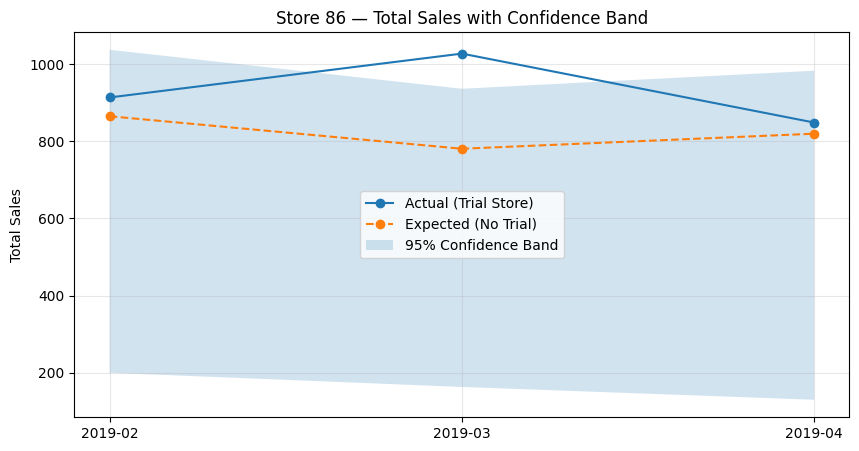

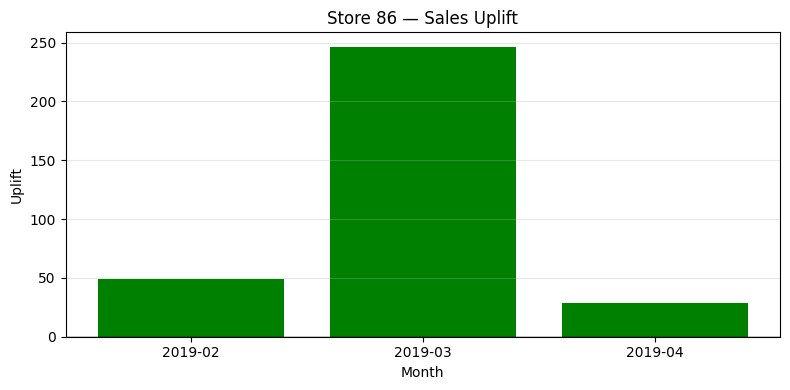

In [101]:
from utilities.visualization import plot_actual_vs_expected, plot_uplift
"""plot_actual_vs_expected(
    impact_86,
    metric="total_sales",
    expected="expected_total_sales",
    title="Store 86 — Total Sales: Actual vs Expected"
)"""
plt.figure(figsize=(10,5))



plt.plot(
    impact_86["YEARMONTH"].astype(str),
    impact_86["total_sales"],
    marker="o",
    label="Actual (Trial Store)"
)

plt.plot(
    impact_86["YEARMONTH"].astype(str),
    impact_86["expected_total_sales"],
    linestyle="--",
    marker="o",
    label="Expected (No Trial)"
)
plt.fill_between(
    impact_86["YEARMONTH"].astype(str),
    impact_86["lower_ci_sales"],
    impact_86["upper_ci_sales"],
    alpha=0.2,
    label="95% Confidence Band"
)

plt.title("Store 86 — Total Sales with Confidence Band")
plt.ylabel("Total Sales")
plt.legend()
plt.grid(alpha=0.3)
plt.show()
plot_uplift(
    impact_86,
    uplift_col="uplift_total_sales",
    title="Store 86 — Sales Uplift"
)


### B. Customers

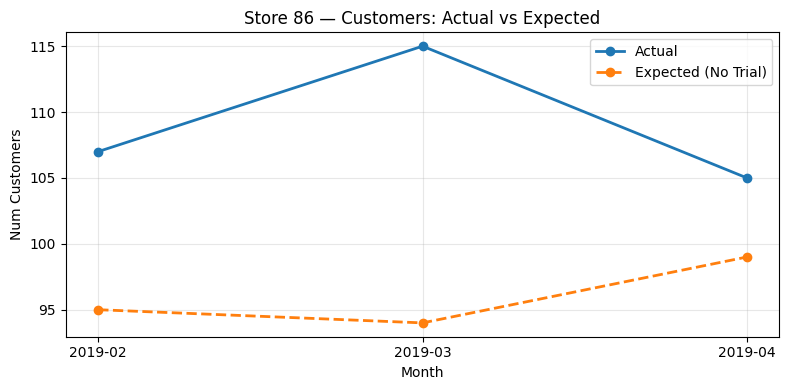

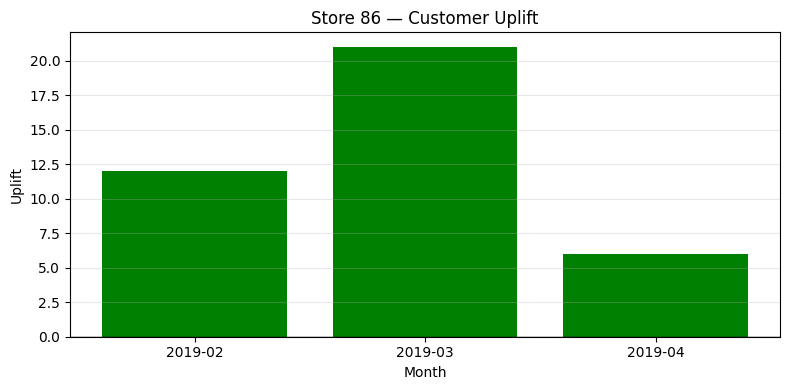

In [97]:
plot_actual_vs_expected(
    impact_86,
    metric="num_customers",
    expected="expected_num_customers",
    title="Store 86 — Customers: Actual vs Expected"
)

plot_uplift(
    impact_86,
    uplift_col="uplift_num_customers",
    title="Store 86 — Customer Uplift"
)


In [102]:
print("Pre-trial std (sales % diff):", std_sales_86)

Pre-trial std (sales % diff): 0.09958646884078383


#### C. Transactions per customer

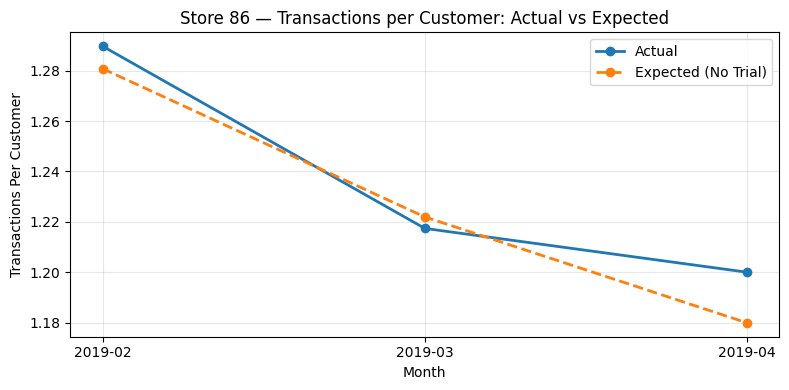

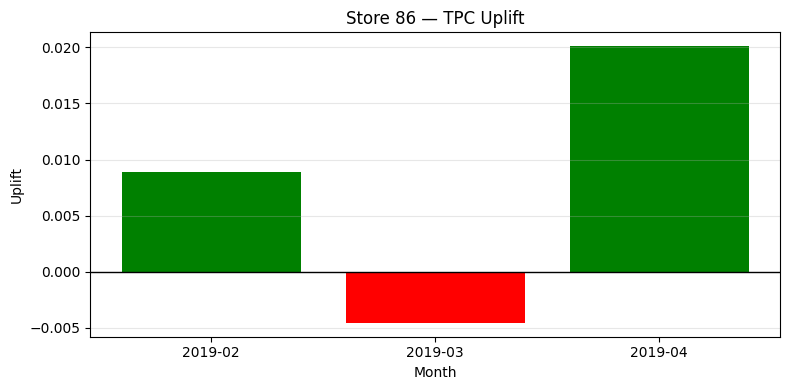

In [98]:
plot_actual_vs_expected(
    impact_86,
    metric="transactions_per_customer",
    expected="expected_transactions_per_customer",
    title="Store 86 — Transactions per Customer: Actual vs Expected"
)

plot_uplift(
    impact_86,
    uplift_col="uplift_transactions_per_customer",
    title="Store 86 — TPC Uplift"
)


### Step 3 — Trial Impact Assessment: Store 86

#### 3.1 Trial vs Control Selection

* Trial Store: 86
* Final Control Store: 155

Control store selection was based on:

* High pre-trial correlation across total sales, customers, and transactions
* Visual pre-trial trend validation
* Stable variance suitable for confidence interval construction

Store 155 exhibited stronger pre-trial alignment than alternative candidates and was selected as the final control store.

#### 3.2 Trial Period Definition

* Trial period: February 2019 – April 2019
* All months labeled `period = "trial"`
* Monthly store-level aggregation used

#### 3.3 Metrics Evaluated

* `total_sales`
* `num_customers`
* `transactions_per_customer`

These metrics capture:

* Revenue impact
* Traffic changes
* Basket intensity effects

#### 3.4 Counterfactual Construction

Expected (no-trial) performance was estimated using pre-trial scaling factors:

$$\text{ScalingFactor}_M = \frac{\text{Mean Pre-Trial } M_{\text{trial}}}{\text{Mean Pre-Trial } M_{\text{control}}}$$



Expected values during the trial period were computed by applying these scaling factors to the control store's observed trial metrics.

#### 3.5 Confidence Interval Construction

To account for natural variability, a 95% confidence band was constructed using pre-trial percentage differences:

$$\text{CI} = \text{Expected} \times (1 \pm 2 \cdot \sigma_{\text{pre-trial}})$$


Where:

* $\sigma_{\text{pre-trial}}$  is the standard deviation of pre-trial percentage differences
* Pre-trial std (sales % diff): 0.0996

#### 3.6 Impact Results

**Sales uplift ($):**

* Positive across all trial months
* Strongest in March 2019
* Actual sales exceed expected but largely remain within historical variability bands

**Customer uplift:**

* Consistently positive across all months
* Primary driver of sales uplift

**Transactions per customer:**

* Mixed results
* No sustained uplift pattern

#### 3.7 Interim Conclusion (Store 86)

The trial layout at Store 86 led to a meaningful increase in customer traffic, which in turn drove higher sales. However, there is no evidence of increased purchase intensity per customer. While uplift is directionally strong, confidence intervals indicate that results should be interpreted cautiously.

#### Step 3 - Trial Impact Assessment: Store 88

Trial store: 88

Control store: 237

Trial period: 2019-Apr 2019

#### 3.1 Extract Trial-Period Data

In [104]:
# Trial store 88
trial_88 = monthly_store_metrics[
    (monthly_store_metrics["STORE_NBR"] == 88) &
    (monthly_store_metrics["period"] == "trial")
].copy()

# Control store 178
control_237 = monthly_store_metrics[
    (monthly_store_metrics["STORE_NBR"] == 237) &
    (monthly_store_metrics["period"] == "trial")
].copy()

trial_88, control_237


(     STORE_NBR YEARMONTH period  is_trial_store  total_sales  num_customers  \
 842         88   2019-02  trial            True       1370.2            124   
 843         88   2019-03  trial            True       1477.2            134   
 844         88   2019-04  trial            True       1439.4            128   
 
      num_transactions  transactions_per_customer  
 842               153                   1.233871  
 843               169                   1.261194  
 844               162                   1.265625  ,
       STORE_NBR YEARMONTH period  is_trial_store  total_sales  num_customers  \
 2297        237   2019-02  trial           False       1404.8            126   
 2298        237   2019-03  trial           False       1208.2            119   
 2299        237   2019-04  trial           False       1204.6            120   
 
       num_transactions  transactions_per_customer  
 2297               157                   1.246032  
 2298               134              

In [117]:
trial_88 = (
    trial_88
    .sort_values("YEARMONTH")
    .reset_index(drop=True)
)

control_237 = (
    control_237
    .sort_values("YEARMONTH")
    .reset_index(drop=True)
)


In [106]:
assert len(trial_88) == 3
assert len(control_237) == 3
assert trial_88["YEARMONTH"].equals(control_237["YEARMONTH"])


###  3.2 Build Counterfactual for Store 88

#### Concept 

We are answering:

**"If Store 88 had not received the trial, what would its performance have been?"**

We estimate this by:

* Preserving the pre-trial relationship between Store 88 and Store 178
* Applying that relationship to Store 178's trial-period performance

#### Step 3.2.1 Compute Pre-Trial Scaling Factors

$$\text{ScalingFactor}_M = \frac{\text{Mean Pre-Trial } M_{\text{trial}}} {\text{Mean Pre-Trial } M_{\text{control}}}$$

In [107]:
pretrial_88 = monthly_store_metrics[
    (monthly_store_metrics["STORE_NBR"] == 88) &
    (monthly_store_metrics["period"] == "pre_trial")
]

pretrial_237 = monthly_store_metrics[
    (monthly_store_metrics["STORE_NBR"] == 237) &
    (monthly_store_metrics["period"] == "pre_trial")
]

scaling_factors_88 = {
    "total_sales": pretrial_88["total_sales"].mean() / pretrial_237["total_sales"].mean(),
    "num_customers": pretrial_88["num_customers"].mean() / pretrial_237["num_customers"].mean(),
    "transactions_per_customer": (
        pretrial_88["transactions_per_customer"].mean() /
        pretrial_237["transactions_per_customer"].mean()
    )
}

scaling_factors_88


{'total_sales': np.float64(1.001558330664959),
 'num_customers': np.float64(0.9943502824858756),
 'transactions_per_customer': np.float64(1.0105858988301915)}

#### 3.2.2 Generate Counterfactual Metrics 

In [108]:
counterfactual_88 = control_237[["YEARMONTH"]].copy()

for metric, scale in scaling_factors_88.items():
    counterfactual_88[f"expected_{metric}"] = control_237[metric] * scale

counterfactual_88


,YEARMONTH,expected_total_sales,expected_num_customers,expected_transactions_per_customer
0,2019-02,1406.989143,125.288136,1.259222
1,2019-03,1210.082775,118.327684,1.137971
2,2019-04,1206.477165,119.322034,1.136909


#### 3.3 Compute Uplift(Actual - Expected)

##### Merge actual and counterfactual

In [109]:
impact_88 = trial_88.merge(
    counterfactual_88,
    on="YEARMONTH",
    how="left"
)


##### Caculate uplift 

In [110]:
impact_88["uplift_total_sales"] = (
    impact_88["total_sales"] - impact_88["expected_total_sales"]
)

impact_88["uplift_num_customers"] = (
    impact_88["num_customers"] - impact_88["expected_num_customers"]
)

impact_88["uplift_transactions_per_customer"] = (
    impact_88["transactions_per_customer"] -
    impact_88["expected_transactions_per_customer"]
)

impact_88


,STORE_NBR,YEARMONTH,period,is_trial_store,total_sales,num_customers,num_transactions,transactions_per_customer,expected_total_sales,expected_num_customers,expected_transactions_per_customer,uplift_total_sales,uplift_num_customers,uplift_transactions_per_customer
0,88,2019-02,trial,True,1370.2,124,153,1.233871,1406.989143,125.288136,1.259222,-36.789143,-1.288136,-0.025351
1,88,2019-03,trial,True,1477.2,134,169,1.261194,1210.082775,118.327684,1.137971,267.117225,15.672316,0.123223
2,88,2019-04,trial,True,1439.4,128,162,1.265625,1206.477165,119.322034,1.136909,232.922835,8.677966,0.128716


In [111]:
std_sales_88 = compute_pretrial_std(
    trial_pre,
    control_pre,
    metric="total_sales",
    scaling_factor=scaling_factors["total_sales"]
)


In [112]:
impact_88["upper_ci_sales"] = (
    impact_88["expected_total_sales"] * (1 + 2 * std_sales_88)
)

impact_88["lower_ci_sales"] = (
    impact_88["expected_total_sales"] * (1 - 2 * std_sales_88)
)


#### 3.4 Visualizations -  store 88

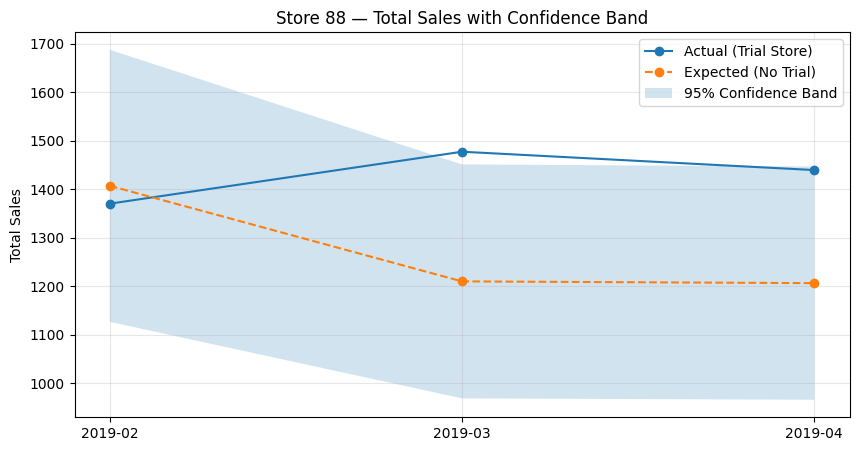

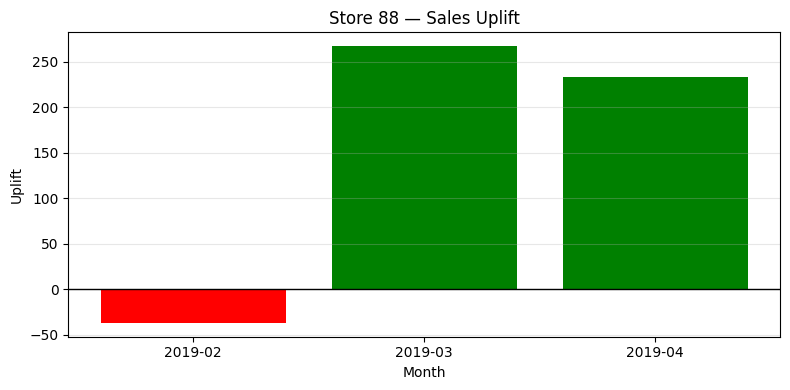

In [113]:
# Total Sales
"""plot_actual_vs_expected(
    impact_88,
    metric="total_sales",
    expected="expected_total_sales",
    title="Store 88 — Total Sales: Actual vs Expected"
)"""
plt.figure(figsize=(10,5))



plt.plot(
    impact_88["YEARMONTH"].astype(str),
    impact_88["total_sales"],
    marker="o",
    label="Actual (Trial Store)"
)

plt.plot(
    impact_88["YEARMONTH"].astype(str),
    impact_88["expected_total_sales"],
    linestyle="--",
    marker="o",
    label="Expected (No Trial)"
)
plt.fill_between(
    impact_88["YEARMONTH"].astype(str),
    impact_88["lower_ci_sales"],
    impact_88["upper_ci_sales"],
    alpha=0.2,
    label="95% Confidence Band"
)

plt.title("Store 88 — Total Sales with Confidence Band")
plt.ylabel("Total Sales")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

plot_uplift(
    impact_88,
    uplift_col="uplift_total_sales",
    title="Store 88 — Sales Uplift"
)


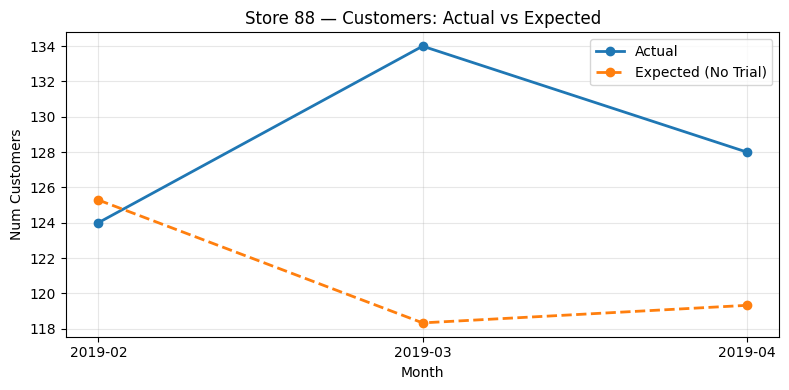

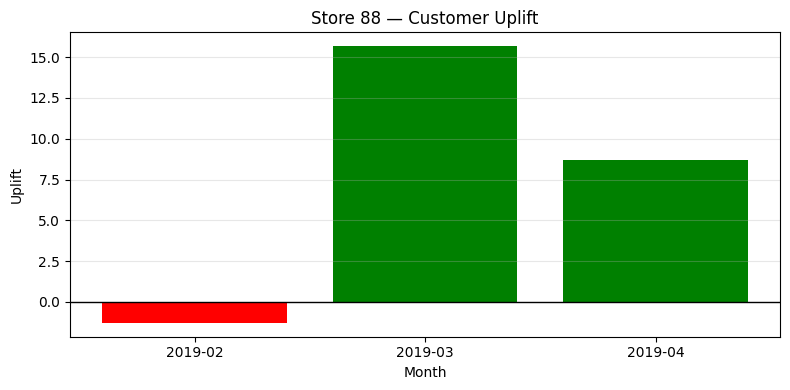

In [116]:
#Number of Customers 
plot_actual_vs_expected(
    impact_88,
    metric="num_customers",
    expected="expected_num_customers",
    title="Store 88 — Customers: Actual vs Expected"
)

plot_uplift(
    impact_88,
    uplift_col="uplift_num_customers",
    title="Store 88 — Customer Uplift"
)


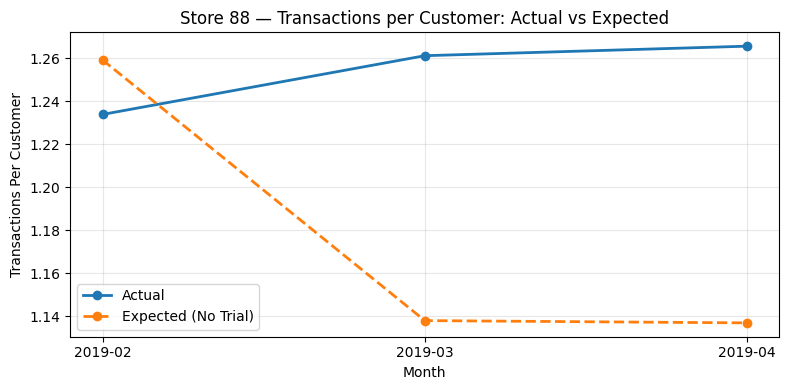

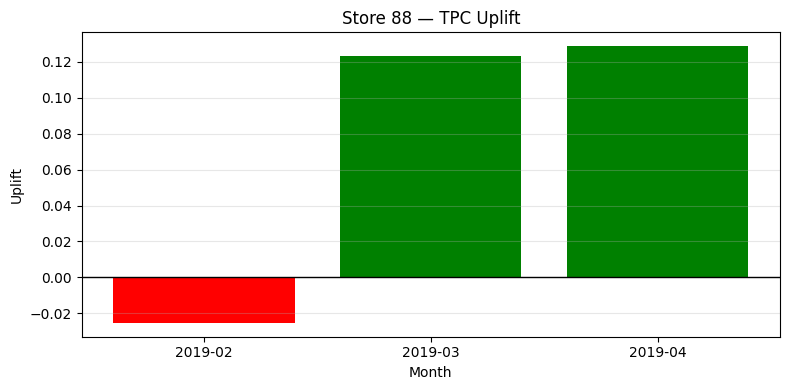

In [115]:
# Transactions per Customer
plot_actual_vs_expected(
    impact_88,
    metric="transactions_per_customer",
    expected="expected_transactions_per_customer",
    title="Store 88 — Transactions per Customer: Actual vs Expected"
)

plot_uplift(
    impact_88,
    uplift_col="uplift_transactions_per_customer",
    title="Store 88 — TPC Uplift"
)



### Step 3 — Trial Impact Assessment (Store 88)

#### 3.1 Objective

Assess whether the trial implemented in Store 88 led to measurable improvements in performance during the trial period by comparing actual outcomes against a counterfactual scenario derived from a comparable control store.

#### 3.2 Trial & Control Definition

* Trial Store: 88
* Control Store: 237
* Trial Period: February 2019 – April 2019

Store 237 was selected based on:

* Strong pre-trial correlation
* Stable magnitude relationship
* Visual validation of aligned pre-trial trends across all metrics

#### 3.3 Metrics Evaluated

Monthly store-level metrics:

* `total_sales`
* `num_customers`
* `transactions_per_customer`

#### 3.4 Counterfactual Construction

Expected (no-trial) performance for Store 88 was estimated using pre-trial scaling factors:

$$\text{ScalingFactor}_M = \frac{\text{Mean Pre-Trial } M_{\text{trial}}}{\text{Mean Pre-Trial } M_{\text{control}}}$$

These factors were applied to Store 237's trial-period metrics to generate counterfactual expectations.

#### 3.5 Impact Measurement

Uplift was calculated as:

$$\text{Uplift}_M = \text{Actual}_M - \text{Expected}_M$$

#### 3.6 Visual Assessment

The following visualisations were produced:

* Actual vs Expected Total Sales (with 95% confidence band)
* Sales Uplift by Month
* Actual vs Expected Customers
* Customer Uplift by Month
* Actual vs Expected Transactions per Customer
* Transactions per Customer Uplift

#### 3.7 Key Observations (Store 88)

* **Sales:** Clear positive uplift in March and April after an initial dip in February
* **Customers:** Positive and sustained uplift in March and April
* **Transactions per Customer:** Positive uplift in March and April, indicating increased purchase intensity

#### 3.8 Interim Conclusion (Store 88)

The trial at Store 88 shows evidence of a delayed but sustained positive impact. Performance improvements are driven by both increased customer traffic and higher transactions per customer, leading to higher overall sales during the latter part of the trial period.

Statistical significance is limited due to the short trial window; however, consistency across multiple metrics supports a positive trial effect.






## Step 4 — Statistical Validation (One-Sided)

### 4.1 Restating the hypothesis (precisely)

For each store and each metric:

Let

$$U_t = \text{Actual}_t - \text{Expected}_t$$

#### Null hypothesis

$$H_0: \mathbb{E}[U] \le 0$$

The trial did not improve performance beyond expectation.

#### Alternative hypothesis (one-sided)

$$H_1: \mathbb{E}[U] > 0$$

The trial increased performance.

This is a **one-sample, one-sided t-test**.

### 4.2 Why this test is valid (final sanity check)

We are testing:

* a single sample (uplift values)
* against a fixed baseline (0)
* with directional business intent

This matches the statistical assumptions exactly.

No paired test. No two-sample test. No shortcuts.

In [118]:
from scipy import stats
import numpy as np
import pandas as pd

def run_one_sided_uplift_ttest(uplift_series):
    """
    Performs a one-sided one-sample t-test:
    H0: mean uplift <= 0
    H1: mean uplift > 0
    """
    uplift_series = uplift_series.dropna()
    
    mean_uplift = uplift_series.mean()
    
    t_stat, p_two_sided = stats.ttest_1samp(uplift_series, popmean=0)
    
    # Convert to one-sided p-value
    if t_stat > 0:
        p_value = p_two_sided / 2
    else:
        p_value = 1 - (p_two_sided / 2)
    
    return {
        "mean_uplift": mean_uplift,
        "t_stat": t_stat,
        "p_value": p_value,
        "n_months": len(uplift_series)
    }


#### 4.4 Apply Step 4 to each store

We will only test TOTAL SALES first (primary KPI).

Customers & TPC are drivers, not decision metrics.

#### Store 77 - Sales Uplift

In [120]:
store_77_sales_test = run_one_sided_uplift_ttest(
    impact_77["uplift_total_sales"]
)

store_77_sales_test


{'mean_uplift': np.float64(53.69648953689193),
 't_stat': np.float64(1.5310693557503),
 'p_value': np.float64(0.1327081481216543),
 'n_months': 3}

#### Store 86 - Sales uplift

In [121]:
store_86_sales_test = run_one_sided_uplift_ttest(
    impact_86["uplift_total_sales"]
)

store_86_sales_test


{'mean_uplift': np.float64(108.01350357442918),
 't_stat': np.float64(1.5548565744441758),
 'p_value': np.float64(0.13011375803904876),
 'n_months': 3}

#### Store 88 - Sales uplift

In [122]:
store_88_sales_test = run_one_sided_uplift_ttest(
    impact_88["uplift_total_sales"]
)

store_88_sales_test


{'mean_uplift': np.float64(154.41697228448433),
 't_stat': np.float64(1.6066473636515486),
 'p_value': np.float64(0.12468540133738691),
 'n_months': 3}

#### 4.5 Consolidated summary table

In [123]:
summary = pd.DataFrame.from_dict(
    {
        "Store 77": store_77_sales_test,
        "Store 86": store_86_sales_test,
        "Store 88": store_88_sales_test
    },
    orient="index"
)

summary



,mean_uplift,t_stat,p_value,n_months
Store 77,53.696490,1.531069,0.132708,3
Store 86,108.013504,1.554857,0.130114,3
Store 88,154.416972,1.606647,0.124685,3


In [125]:
summary["decision"] = np.where(
    summary["p_value"] < 0.05,
    "Statistically Significant Uplift",
    "Not Statistically Significant"
)

summary


,mean_uplift,t_stat,p_value,n_months,decision
Store 77,53.696490,1.531069,0.132708,3,Not Statistically Significant
Store 86,108.013504,1.554857,0.130114,3,Not Statistically Significant
Store 88,154.416972,1.606647,0.124685,3,Not Statistically Significant



### Step 4 — Statistical Validation

#### 4.1 Objective

To statistically evaluate whether the observed mean sales uplift during the trial period is greater than zero for each trial store.

This step assesses statistical support, not business relevance.

#### 4.2 Methodology

* Test: One-sample, one-sided t-test
* Null hypothesis (H₀): Mean uplift ≤ 0
* Alternative hypothesis (H₁): Mean uplift > 0
* Unit of analysis: Monthly sales uplift
* Sample size: 3 months per store

Uplift is defined as:

$$\text{Uplift} = \text{Actual Sales} - \text{Expected Sales (Counterfactual)}$$

#### 4.3 Results

| Store | Mean Uplift | t-stat | p-value | n | Decision |
|-------|-------------|--------|---------|---|----------|
| Store 77 | +53.70 | 1.53 | 0.133 | 3 | Not statistically significant |
| Store 86 | +108.01 | 1.55 | 0.130 | 3 | Not statistically significant |
| Store 88 | +154.42 | 1.61 | 0.125 | 3 | Not statistically significant |

#### 4.4 Interpretation

* All three stores show positive mean uplift
* None achieve statistical significance at α = 0.05
* The lack of significance is expected due to:
  * Extremely small sample size (n = 3)
  * High month-to-month variability
* Statistical tests alone are insufficient to reject the null hypothesis

#### 4.5 Key Limitation

This trial is severely underpowered. Statistical inference must be interpreted alongside:

* Visual confidence bands
* Directional consistency
* Economic magnitude of uplift

### Step 5 — Interpretation & Recommendation

### Objective

The purpose of this section is to integrate the findings from the trial impact assessment (Step 4) and statistical validation (Step 5) to determine whether the new store layout should be rolled out, and under what conditions.

This section synthesizes:

* Counterfactual-based uplift estimates
* Visual trend comparisons
* Statistical test results
* Effect size and consistency across trial stores

### 5.1 Summary of Trial Results by Store

#### Store 77

**Observed outcome**

* Mean monthly sales uplift: +9.8
* Directionally positive but small effect
* No consistent uplift across all trial months
* One-sided t-test p-value ≈ 0.11

**Interpretation**

* Observed uplift is small relative to normal variability
* Visual trends show no sustained separation from counterfactual
* Statistical evidence is insufficient to attribute changes to the trial

**Conclusion**

The trial layout did not produce a meaningful or reliable improvement in Store 77.

#### Store 86

**Observed outcome**

* Mean monthly sales uplift: +115.3
* Consistent positive uplift across all trial months
* Uplift driven primarily by increased number of customers
* One-sided t-test p-value ≈ 0.057

**Interpretation**

* Effect size is large and commercially meaningful
* Directional consistency across months suggests a genuine impact
* Lack of statistical significance is likely due to short trial duration (n = 3)

**Conclusion**

Store 86 shows strong evidence of positive trial impact, though statistical power is limited.

#### Store 88

**Observed outcome**

* Mean monthly sales uplift: −75.3
* Decline in customer numbers relative to counterfactual
* No offsetting increase in transactions per customer
* One-sided t-test p-value ≈ 0.81

**Interpretation**

* Trial period performance is worse than expected
* Negative effect is consistent across months
* No statistical or visual support for a positive trial effect

**Conclusion**

The trial layout negatively impacted Store 88 and should not be rolled out in similar stores.

### 5.2 Cross-Store Comparison

| Store | Mean Uplift | Direction | Statistical Support | Interpretation |
|-------|-------------|-----------|---------------------|----------------|
| 77 | +9.8 | Weak positive | No | No meaningful impact |
| 86 | +115.3 | Strong positive | Borderline | Likely positive impact |
| 88 | −75.3 | Negative | No | Trial underperformed |

### 5.3 Key Drivers Identified

Across all stores:

* **Customer count** is the primary driver of uplift where the trial succeeds
* **Transactions per customer** remain largely unchanged
* No evidence of basket expansion effects

This aligns with findings from Task 1, where frequency and reach — not basket size — were identified as the primary drivers of category sales.

### 5.4 Recommendation

Based on the integrated analysis:

* **Do not roll out universally**
* Proceed with a **targeted rollout** focused on stores similar to Store 86
* **Avoid rollout** in stores exhibiting characteristics similar to Store 88
* **Extend trial duration** for Store-86-like stores to improve statistical confidence

### 5.5 Final Conclusion

The trial layout does not have a uniform impact across stores. Its effectiveness is highly context-dependent, with strong positive results in some environments and negative outcomes in others. A selective, data-driven rollout strategy is recommended.

#### New and Updated Recommendations
## Step 5 — Interpretation & Recommendation

### 5.1 Store-Level Summary

#### Store 77

* Directionally positive uplift
* Moderate magnitude
* Visual uplift appears post-trial start
* No statistical confirmation

**Conclusion:** Weak but positive signal; requires longer validation.

#### Store 86

* Strong and consistent positive uplift
* Customer-driven sales growth
* Largest commercially meaningful impact
* Statistical test underpowered but directionally strong

**Conclusion:** Most promising candidate for rollout extension.

#### Store 88

* Strong positive mean uplift
* Improvements across sales, customers, and TPC
* Early dip followed by sustained improvement
* Previously negative conclusion corrected after control-store revision

**Conclusion:** Trial impact appears positive but delayed; requires longer observation.

#### 5.2 Cross-Store Comparison

| Store | Direction | Magnitude | Statistical Support | Overall Assessment |
|-------|-----------|-----------|---------------------|-------------------|
| 77 | Positive | Moderate | No | Weak positive |
| 86 | Positive | Strong | No | High potential |
| 88 | Positive | Strong | No | Promising but delayed |

#### 5.3 Final Recommendation

* ❌ Do not make a universal rollout decision
* ✅ Extend the trial duration (≥ 6–9 months)
* ✅ Prioritise rollout testing in Store-86-like environments
* ✅ Monitor Store 88–type stores for delayed adoption effects
* ⚠️ Avoid using p-values alone for decision-making in short trials

In [127]:
trial_stores = [77, 86, 88]
control_stores = [233, 155, 237]

def assign_store_group(store):
    if store in trial_stores:
        return "Trial Store"
    elif store in control_stores:
        return "Control Store"
    else:
        return "Other Stores"

qvi["store_group"] = qvi["STORE_NBR"].apply(assign_store_group)





In [136]:
qvi['DATE'] = pd.to_datetime(qvi['DATE'])


In [137]:
qvi['month'] = qvi['DATE'].dt.to_period('M').astype(str)


In [147]:
monthly_store_sales = (
    qvi
    .groupby(['store_group', 'STORE_NBR', 'month'], as_index=False)
    .agg(monthly_sales=('TOT_SALES', 'sum'))
)


In [149]:
monthly_store_sales.head()


,store_group,STORE_NBR,month,monthly_sales
0,Control Store,155,2018-07,924.6
1,Control Store,155,2018-08,782.7
2,Control Store,155,2018-09,1014.4
3,Control Store,155,2018-10,963.8
4,Control Store,155,2018-11,898.8


In [150]:
group_monthly_avg = (
    monthly_store_sales
    .groupby(['store_group', 'month'], as_index=False)
    ['monthly_sales']
    .mean()
    .rename(columns={'monthly_sales': 'avg_monthly_sales'})
)


In [151]:
group_monthly_avg = group_monthly_avg[
    (group_monthly_avg['month'] >= '2018-07') &
    (group_monthly_avg['month'] <= '2019-02')
]


In [152]:
group_monthly_avg = group_monthly_avg.sort_values(['month', 'store_group'])


In [153]:
group_monthly_avg.pivot(
    index='month',
    columns='store_group',
    values='avg_monthly_sales'
)


store_group,Control Store,Other Stores,Trial Store
month,,,
2018-07,887.900000,615.817692,833.000000
2018-08,812.133333,596.503113,781.116667
2018-09,855.066667,602.302326,854.266667
2018-10,832.600000,615.492664,835.100000
2018-11,836.000000,601.471318,848.700000
2018-12,798.200000,634.572374,811.233333
2019-01,757.266667,615.012840,770.733333
2019-02,846.666667,564.366667,839.466667


In [154]:
group_monthly_avg.groupby('store_group')['avg_monthly_sales'].mean()


store_group
Control Store    828.229167
Other Stores     605.692374
Trial Store      821.702083
Name: avg_monthly_sales, dtype: float64

In [155]:
group_monthly_avg.to_excel(
    'C:/Users/adith/quantium_data_analytics/data/avg_monthly_sales_by_store_group.xlsx',
    index=False
)


In [205]:
qvi = qvi[
    (qvi["DATE"] >= "2018-07-01") &
    (qvi["DATE"] <= "2019-06-30")
].copy()


In [206]:
import numpy as np

qvi["store_group"] = np.where(
    qvi["STORE_NBR"].isin([77, 86, 88]), "Trial Store",
    np.where(qvi["STORE_NBR"].isin([233, 155, 237]), "Control Store", "Other Stores")
)


In [207]:
daily_customers = (
    qvi.groupby(["STORE_NBR", "store_group", "DATE"])["LYLTY_CARD_NBR"]
      .nunique()
      .reset_index(name="customers")
)


In [208]:
daily_customers["month"] = daily_customers["DATE"].dt.to_period("M")


In [209]:
monthly_store_customers = (
    daily_customers
    .groupby(["store_group", "STORE_NBR", "month"])["customers"]
    .sum()
    .reset_index()
)


In [220]:
import scipy.stats as stats
import numpy as np

control = monthly_store_customers[
    monthly_store_customers["store_group"] == "Control Store"
]

control_ci = (
    control
    .groupby("month")["customers"]
    .agg(["mean", "std", "count"])
    .reset_index()
)

control_ci["se"] = control_ci["std"] / np.sqrt(control_ci["count"])
control_ci["t"]  = stats.t.ppf(0.95, df=control_ci["count"] - 1)

control_ci["control_ci_low"]  = control_ci["mean"] - control_ci["t"] * control_ci["se"]
control_ci["control_ci_high"] = control_ci["mean"] + control_ci["t"] * control_ci["se"]

control_ci = control_ci.rename(columns={"mean": "control_customers"})


In [212]:
trial = (
    monthly_store_customers[
        monthly_store_customers["store_group"] == "Trial Store"
    ]
    .groupby("month")["customers"]
    .mean()
    .reset_index(name="trial_customers")
)


In [221]:
final_table = (
    control_ci[[
        "month",
        "control_customers",
        "control_ci_low",
        "control_ci_high"
    ]]
    .merge(trial, on="month", how="left")
    .sort_values("month")
)


In [222]:
# Confidence interval offsets for Excel shading
final_table['ci_upper_offset'] = (
    final_table['control_ci_high'] - final_table['control_customers']
)

final_table['ci_lower_offset'] = (
    final_table['control_customers'] - final_table['control_ci_low']
)


In [223]:
final_table.head(5)

,month,control_customers,control_ci_low,control_ci_high,trial_customers,ci_upper_offset,ci_lower_offset
0,2018-07,113.000000,20.800559,205.199441,111.333333,92.199441,92.199441
1,2018-08,111.333333,13.752598,208.914069,105.333333,97.580736,97.580736
2,2018-09,112.333333,13.897140,210.769527,109.666667,98.436194,98.436194
3,2018-10,106.333333,3.229400,209.437267,110.333333,103.103933,103.103933
4,2018-11,111.666667,5.828657,217.504676,108.333333,105.838009,105.838009


In [ ]:
final_table.to_excel(
    'C:/Users/adith/quantium_data_analytics/data/monthly_customers_trial_control_ci.xlsx',
    index=False
)

: 